In [20]:
#import packages
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LinearRegression
import altair as alt
from docopt import docopt


import warnings
warnings.filterwarnings('ignore')

# opt = docopt(__doc__)


def fit_and_report(model, X, y, Xv, yv, mode = 'regression'):
    """
    report the error of a model, if it is a regression model, scoring uses mean square error
    if it is a classification model, scoring uses regular accuray
    
    Parameters
    ----------
    X: numpy.ndarray        
        The X part of the train set
    y: numpy.ndarray
        The y part of the train set    
    Xv: numpy.ndarray        
        The X part of the validation set
    yv: numpy.ndarray
        The y part of the validation set 
    model: string 
        whether the model is a 'regression' model or 'classification',
        default value is 'regression'
        
    Returns
    -------
        errors: float
    """
    model.fit(X, y)
    if mode.lower().startswith('regress'):
        errors = [mean_squared_error(y, model.predict(X)), mean_squared_error(yv, model.predict(Xv))]
    if mode.lower().startswith('classif'):
        errors = [1 - model.score(X,y), 1 - model.score(Xv,yv)]  
    
    # tests
    assert len(errors) ==2, 'the len of errors is 2'
    
    return errors

In [21]:
output = '../results'

In [78]:
X_train = pd.read_csv("../data/processed/X_train.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df = pd.DataFrame(columns = ['n_features_to_select','Train_error', 'Test_error']) 

for n in range(1,11):
    lr = LinearRegression()
    rfe = RFE(estimator = lr, n_features_to_select = n)
    rfe.fit(X_train, y_train)
    X_train_sel = X_train_scaled[:, rfe.support_]
    X_test_sel = X_test_scaled[:, rfe.support_]
    errors = fit_and_report(lr, X_train_sel, y_train, X_test_sel, y_test, mode='regression')
    df = df.append({'n_features_to_select':n, 'Train_error':errors[0], 'Test_error':errors[1]},ignore_index = True)

df = pd.melt(df, id_vars=['n_features_to_select'], value_vars=['Train_error','Test_error'],
            var_name='error_type', value_name='value')


feature_plot = alt.Chart(df).mark_line().encode(
    x='n_features_to_select:N',
    y='value:Q',
    color = 'error_type'
).configure_scale(round = True).configure_axisX(labelAngle=0)


feature_plot.configure(
).properties(
    title = "The relationship between MSE and number of features",
    width = 800,
    height = 400
).save(output+ "/ranked_features.png")


lr = LinearRegression()
rfe = RFE(estimator = lr, n_features_to_select = 6)
rfe.fit(X_train, y_train)


X_train_sel = X_train_scaled[:, rfe.support_]
X_test_sel = X_test_scaled[:, rfe.support_]

lr.fit(X_train_sel,y_train)
errors = fit_and_report(lr, X_train_sel, y_train, X_test_sel, y_test, mode='regression')
print(errors)

relevant_features_bool=rfe.support_
relevant_features_list = pd.DataFrame(list(X_train.iloc[:,relevant_features_bool].columns))
relevant_features_list

relevant_features_list['weights'] = lr.coef_[0]
relevant_features_list= relevant_features_list.rename(columns={0: "features"})

# test
assert len(relevant_features_list) == 6, 'The dimension of y_pred_df is wrong'


print(relevant_features_list)

feature_weight_plot = alt.Chart(relevant_features_list).mark_bar().encode(
    alt.X('features:N', sort=alt.EncodingSortField(field="features", op="count", order='ascending')),
    y='weights:Q'
).configure_axisX(labelFontSize= 15,labelAngle= -45)


feature_weight_plot.configure(
).properties(
    title = "The feature weights",
    width = 800,
    height = 400
).save(output+"/feature_weight_plot.png")


y_pred_df = pd.DataFrame(lr.predict(X_test_sel))
y_pred_df = y_pred_df.rename(columns={0: "predicted"})
y_true_df = y_test.rename(columns={'quality': "actual"})

result_df = pd.concat([y_pred_df, y_true_df], axis=1)

plot_result = alt.Chart(result_df).mark_boxplot().encode(
    alt.X('actual:O',scale=alt.Scale(zero=False)),
    alt.Y('predicted',scale=alt.Scale(zero=False))
).configure_axisX(labelFontSize= 15,labelAngle= -45)

plot_result.configure(
    numberFormat="0.4f"
).properties(
    title = "The prediction result",
    width = 800,
    height = 400
).save('../results'+ "/prediction_result.png")

print('This is the end of analysis, Hooray!!!')

[0.43580028780542784, 0.3821061522987752]
           features   weights
0  volatile_acidity -0.193340
1         chlorides -0.092570
2           density -0.014193
3                ph -0.072133
4         sulphates  0.143803
5           alcohol  0.326660
This is the end of analysis, Hooray!!!


In [57]:
result_df

,predicted,actual
0,5.671702,5
1,5.449555,6
2,6.038408,6
3,5.701823,6
4,6.638019,6
...,...,...
315,5.668356,5
316,5.151744,5
317,5.027941,5
318,6.199834,7


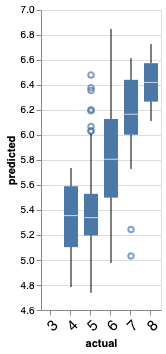

In [77]:
alt.Chart(result_df).mark_boxplot().encode(
    alt.X('actual:O',scale=alt.Scale(zero=False)),
    alt.Y('predicted',scale=alt.Scale(zero=False))
).configure_axisX(labelFontSize= 15,labelAngle= -45)